In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn import linear_model
from aggregate_functions import preprocessing_data, regression_model_items, optimization_fitting

## Contents
1. Basic exploratory analysis
1. Modeling details

### Basic exploratory analysis of current data
- check total demand of each day
- the undiscounted price of the item
- are most items on discount each day

#### Total demand of each day
- huge spikes on days --> influenced by sales

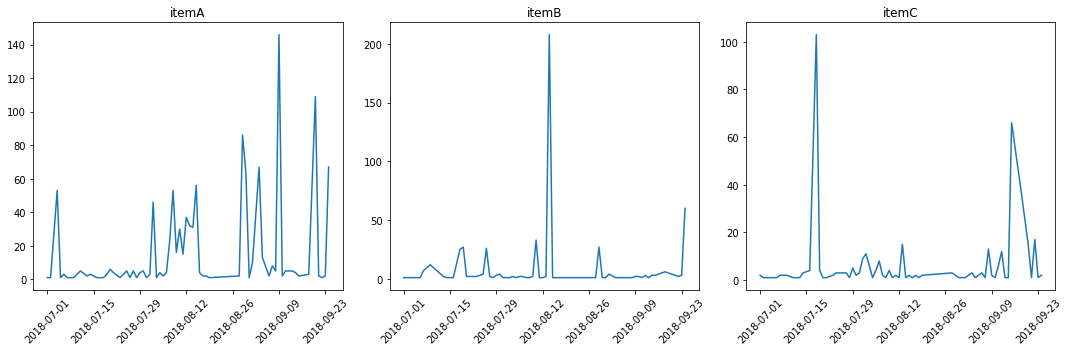

In [110]:
total_demand = (
    processing_data.include_predictors_processed
    .groupby(['date_id','itemid'])
    .agg({"amount":"sum"})
    .reset_index()
)

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
plt.plot(total_demand.query("itemid=='A'").date_id, total_demand.query("itemid=='A'").amount)
plt.title("itemA")
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.plot(total_demand.query("itemid=='B'").date_id, total_demand.query("itemid=='B'").amount)
plt.title("itemB")
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.plot(total_demand.query("itemid=='C'").date_id, total_demand.query("itemid=='C'").amount)
plt.title("itemC")
plt.xticks(rotation=45)


plt.tight_layout()


#### Undiscounted price of each item
- item A: ~53
- item B: ~123
- item C: ~105

In [123]:
undiscounted_price = (
    processing_data.include_predictors_processed
    .groupby(['price_before_discount_usd','itemid'])
    .agg({"amount":"sum"})
    .reset_index()
)
undiscounted_price

,price_before_discount_usd,itemid,amount
0,51.922137,A,458
1,53.170178,A,515
2,53.434224,A,112
3,102.744274,C,21
4,105.240356,C,158
5,105.768448,C,54
6,108.419489,C,36
7,109.162417,C,143
8,110.075197,C,3
9,110.700038,C,2


#### Amount of items sold on discount each day
- it seems like most of the items sold on each day has some of discount
- this hints to us that there are multiple price points of each item, and a multiple regression is suited to tackle this problem

In [70]:
are_most_on_discount = (
    processing_data.include_predictors_processed
    .groupby(['date_id','itemid'])
    .agg({"amount":"sum","is_discount":"sum"})
    .reset_index()
    .pipe(lambda x:x.assign(percentage = x.is_discount/x.amount))
)

are_most_on_discount.percentage.unique()

array([1.])

### Model details
1. Demand generation forecast
1. Accuracy of demand generation
1. Price optimization

### Demand generation forecast
- based on:
    - price of all other products
    - is promotion present
    - is-weekday
    - is-weekend
    - is-holiday
    - previous period demand (introduce auto-correlation of some sort)
    - log-level (not always)
- each product will have a representation
- Example:
    - $\beta_{0} + \beta_{1}P_{i} + \beta_{2}PromotionPresent + \beta_{3}isWeekDay + \beta_{4}isWeekEnd + \beta_{5}isHoliday + \beta_{6}PreviousPeriodDemand + \epsilon$

In [114]:
processing_data = preprocessing_data.PreprocessingData("data/unknown-2018.csv","data/indo_public_holidays.csv")

processing_data.total_demand_A.head()

,date_id,itemid,is_weekday,is_weekend,is_holiday,amount,weighted_price_usd,previous_day_demand,is_promotion
0,2018-07-01,A,0,1,0.0,1,49.869566,0.0,1
1,2018-07-02,A,1,0,0.0,1,49.869566,1.0,1
2,2018-07-04,A,1,0,0.0,53,37.644807,1.0,1
3,2018-07-05,A,1,0,0.0,1,50.725084,53.0,1
4,2018-07-06,A,1,0,0.0,3,50.725084,1.0,1


### Demand generation forecast

In [115]:
regression_model_output = regression_model_items.RegressionModel('data/output_numbers_A.csv','data/regressionB.csv','data/regressionC.csv')

### Accuracy of demand generation

Start of item A:
average quantity demanded for A across time series: 16.44
RMSE for A: 1.52
error margin for A: 0.09


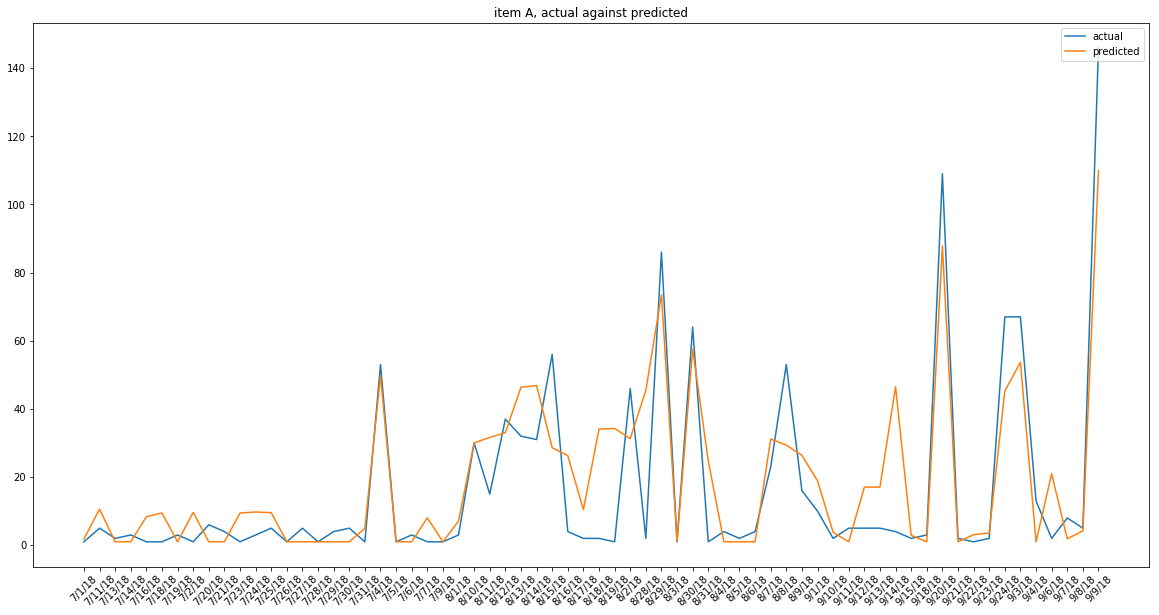

Start of item B:
average quantity demanded for B across time series: 8.06
RMSE for B: 1.92
error margin for B: 0.24


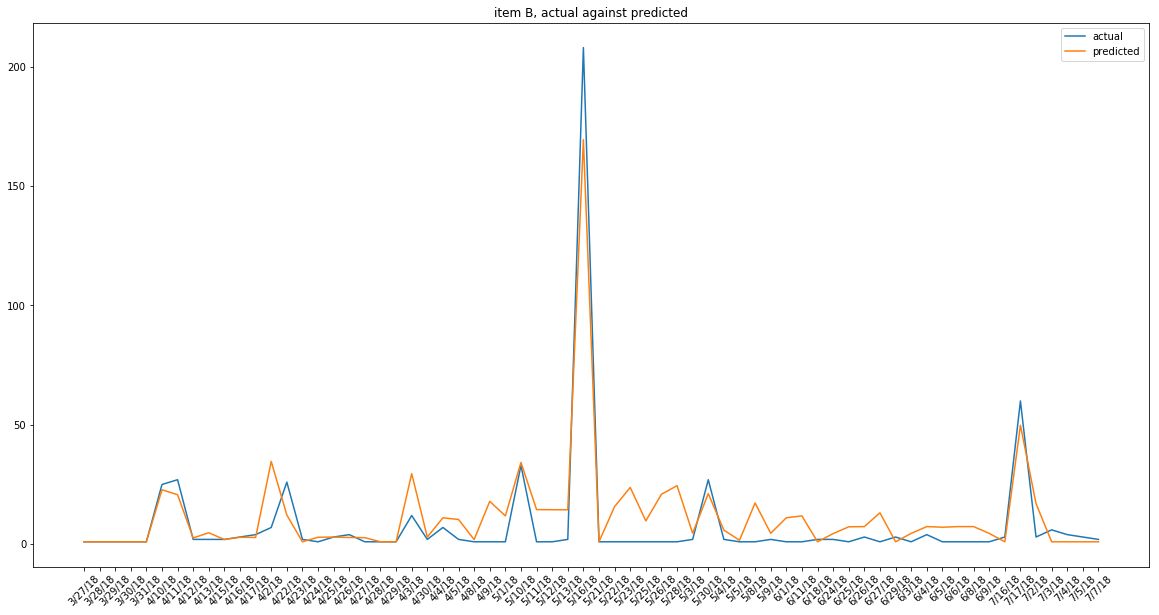

Start of item C:
average quantity demanded for C across time series: 6.32
RMSE for C: 1.11
error margin for C: 0.18


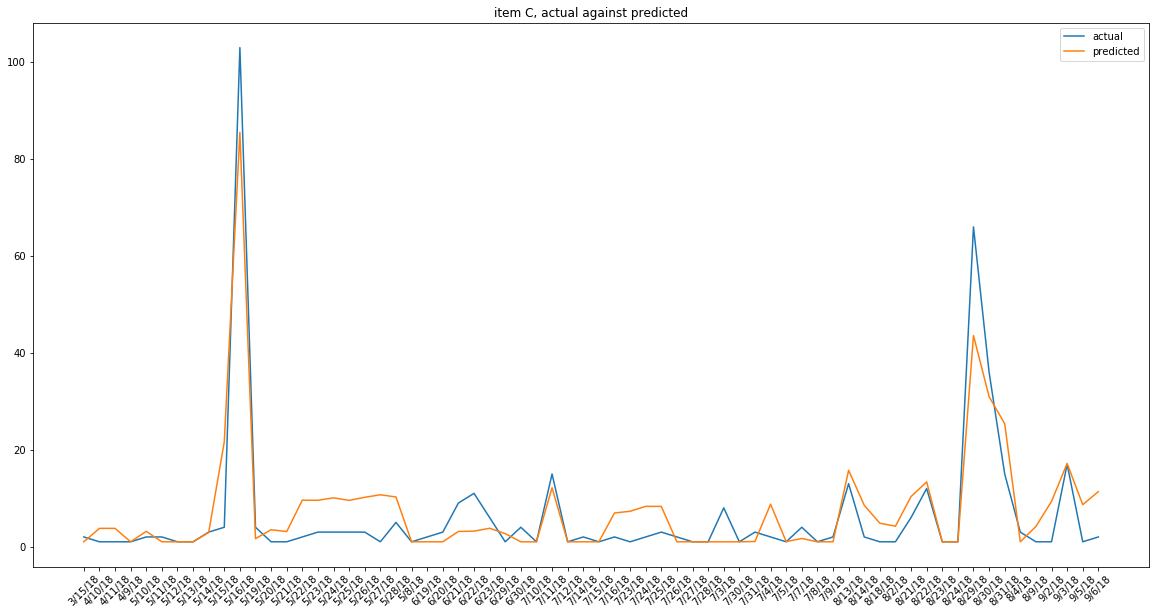

In [116]:
fitting_of_model = optimization_fitting.ModelFitting('data/output_prediction_A.csv','data/output_prediction_B.csv','data/output_prediction_C.csv')

### Price optimization
- The basic idea is we have Q in terms of P
- $TotalRev$ = $Q_a$ * $P_a$ + $Q_b$ * $P_b$ + $Q_c$ * $P_c$
    - optimizing revenue, we will partial differentiate the revenue with respect to each item
    - $\frac{\partial TotalRev}{\partial P_a} = 0$, $\frac{\partial TotalRev}{\partial P_b} = 0$, $\frac{\partial TotalRev}{\partial P_c} = 0$
    - it becomes a system of linear equation, and can be solved easily

In [36]:
def generic_price_optimization_function(is_weekday, is_weekend, is_holiday, 
                                        is_promotion_first, is_promotion_second,
                                        model_param_A, model_param_B, model_param_C):
    model_param_A_df = (
        pd.DataFrame(testing_model.model_params_A)
        .T
    )
    
    model_param_B_df = (
        pd.DataFrame(testing_model.model_params_B)
        .T
    )
    
    model_param_C_df = (
        pd.DataFrame(testing_model.model_params_C)
        .T
    )
    
    constant_A = (
        model_param_A_df.const.values[0] + is_weekday * model_param_A_df.is_weekday.values[0] 
        + is_weekend * model_param_A_df.is_weekend.values[0] + is_holiday * model_param_A_df.is_holiday.values[0]
        + fitting_of_model.prediction_fitting_A * model_param_A_df.previous_day_demand.values[0]
        + is_promotion_first * model_param_A_df.is_promotion_B.values[0]
        + is_promotion_second * model_param_A_df.is_promotion_C.values[0]
    )
    
    constant_B = (
        model_param_B_df.const.values[0] + is_weekday * model_param_B_df.is_weekday.values[0] 
        + is_weekend * model_param_B_df.is_weekend.values[0] + is_holiday * model_param_B_df.is_holiday.values[0]
        + fitting_of_model.prediction_fitting_B * model_param_B_df.previous_demand.values[0]
        + is_promotion_first * model_param_B_df.is_promotion_A.values[0]
        + is_promotion_second * model_param_B_df.is_promotion_C.values[0]
    )
    
    constant_C = (
        model_param_C_df.const.values[0] + is_weekday * model_param_C_df.is_weekday.values[0] 
        + is_weekend * model_param_C_df.is_weekend.values[0] + is_holiday * model_param_C_df.is_holiday.values[0]
        + fitting_of_model.prediction_fitting_C * model_param_C_df.previous_demand.values[0]
        + is_promotion_first * model_param_C_df.is_promotion_B.values[0]
        + is_promotion_second * model_param_C_df.is_promotion_A.values[0]
    )
    
    constant_numeric = np.array([[-1*constant_A],[-1*constant_B],[-1*constant_C]])
    
    item_A_first = model_param_A_df.weighted_price_usd_A.values[0] * 2
    item_A_second = model_param_A_df.weighted_price_usd_B.values[0] + model_param_B_df.weighted_price_usd_A.values[0]
    item_A_third = model_param_A_df.weighted_price_usd_C.values[0] + model_param_C_df.weighted_price_usd_A.values[0]
    
    item_B_first =item_A_second
    item_B_second = model_param_B_df.weighted_price_usd_B.values[0] * 2
    item_B_third = model_param_B_df.weighted_price_usd_C.values[0] + model_param_C_df.weighted_price_usd_B.values[0]
    
    item_C_first = item_A_third
    item_C_second = model_param_C_df.weighted_price_usd_B.values[0] + model_param_B_df.weighted_price_usd_C.values[0]
    item_C_third = model_param_C_df.weighted_price_usd_C.values[0] * 2
    
    model_variables_matrix = np.array([[item_A_first, item_A_second, item_A_third],[item_B_first,item_B_second,item_B_third],[item_C_first,item_C_second,item_C_third]])
    
    values = np.linalg.solve(model_variables_matrix, constant_numeric)
    return values
    

In [117]:
generic_price_optimization_function(1,0,0,0,0,model_param_A_df,model_param_B_df,model_param_C_df)

array([[17.88810439],
       [41.13139183],
       [81.72909101]])

### Recommendations for price
- A: 53 to 17.89
- B: 123 to 41.13
- C: 105 to 81.73

### Expected uplife in revenue from recommendation
- using the same constraint as above
    - is_weekday: 1
    - is_weekend: 0
    - is_holiday: 0
    - is_promotion_first: 0
    - is_promotion_second: 0
- +34% uplift in revenue

In [158]:
original_demand_A =  (
    model_param_A_df.const.values[0] 
    + model_param_A_df.is_weekday.values[0]
    + model_param_A_df.previous_day_demand.values[0] * 16.44 
    + model_param_A_df.weighted_price_usd_A.values[0] * original_price_A
    + model_param_A_df.weighted_price_usd_B.values[0] * original_price_B 
    + model_param_A_df.weighted_price_usd_C.values[0] * original_price_C
)

new_demand_A =  (
    model_param_A_df.const.values[0] 
    + model_param_A_df.is_weekday.values[0]
    + model_param_A_df.previous_day_demand.values[0] * 16.44 
    + model_param_A_df.weighted_price_usd_A.values[0] * 17.88810439
    + model_param_A_df.weighted_price_usd_B.values[0] * 41.13139183 
    + model_param_A_df.weighted_price_usd_C.values[0] * 81.72909101
)

In [159]:
original_demand_B =  (
    model_param_B_df.const.values[0] 
    + model_param_B_df.is_weekday.values[0]
    + model_param_B_df.previous_demand.values[0] * 8.06
    + model_param_B_df.weighted_price_usd_A.values[0] * original_price_A
    + model_param_B_df.weighted_price_usd_B.values[0] * original_price_B 
    + model_param_B_df.weighted_price_usd_C.values[0] * original_price_C
)

new_demand_B =  (
    model_param_B_df.const.values[0] 
    + model_param_B_df.is_weekday.values[0]
    + model_param_B_df.previous_demand.values[0] * 8.06
    + model_param_B_df.weighted_price_usd_A.values[0] * 17.88810439
    + model_param_B_df.weighted_price_usd_B.values[0] * 41.13139183 
    + model_param_B_df.weighted_price_usd_C.values[0] * 81.72909101
)

In [160]:
original_demand_C =  (
    model_param_C_df.const.values[0] 
    + model_param_C_df.is_weekday.values[0]
    + model_param_C_df.previous_demand.values[0] * 6.32
    + model_param_C_df.weighted_price_usd_A.values[0] * original_price_A
    + model_param_C_df.weighted_price_usd_B.values[0] * original_price_B 
    + model_param_C_df.weighted_price_usd_C.values[0] * original_price_C
)

new_demand_C =  (
    model_param_C_df.const.values[0] 
    + model_param_C_df.is_weekday.values[0]
    + model_param_C_df.previous_demand.values[0] * 6.32
    + model_param_C_df.weighted_price_usd_A.values[0] * 17.88810439
    + model_param_C_df.weighted_price_usd_B.values[0] * 41.13139183 
    + model_param_C_df.weighted_price_usd_C.values[0] * 81.72909101
)

In [161]:
original_total_revenue = (
    original_demand_A * original_price_A
    + original_demand_B * original_price_B
    + original_demand_C * original_price_C
)

new_total_revenue = (
    new_demand_A * 17.88810439
    + new_demand_B * 41.13139183 
    + new_demand_C * 81.72909101
)

print("Original total revenue: $" + str(round(original_total_revenue,2)))
print("New total revenue: $" + str(round(new_total_revenue,2)))
print("percentage increase in revenue: " + str(round((new_total_revenue/original_total_revenue-1) * 100,2)) + "%")

Original total revenue: $18305.72
New total revenue: $24514.65
percentage increase in revenue: 33.92%
